In this notebook, we will use another dataset from Kaggle, the skin cancer dataset of malignant VS benign ([Kaggle link](https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign)) as another use case when using a larger curated dataset. This data was obtained from the International Skin Imaging Collaboration (ISIC) organization.

In this notebook, we will use transfer learning, i.e. to make use of models that have been trained on larger and more general datasets (usually the [ImageNet](https://www.image-net.org/about.php) dataset). We use these **pre-trained models** as our foundation and fine-tune it for our custom task. This usually works very well because the models have already learnt to distinguish a lot of different features about our world, so we just train it to focus on our specific task. 

Transfer learning also makes training much faster and usually result in better performance compared to building and training our own model from scratch. Therefore, in most cases, transfer learning is preferred.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# most import image processing library, OpenCV as cv2
import cv2
from imutils.paths import list_images

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

In [2]:
# check whether have access to GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Keras Applications preprocess_input and func

In [3]:
# to get the architecture's module name to obtain preprocess_input func
arch2module_name = {
    "DenseNet121": 'densenet',
    "DenseNet169": 'densenet',
    "DenseNet201": 'densenet',
    "EfficientNetB0": 'efficientnet',
    "EfficientNetB1": 'efficientnet',
    "EfficientNetB2": 'efficientnet',
    "EfficientNetB3": 'efficientnet',
    "EfficientNetB4": 'efficientnet',
    "EfficientNetB5": 'efficientnet',
    "EfficientNetB6": 'efficientnet',
    "EfficientNetB7": 'efficientnet',
    "InceptionResNetV2": 'inception_resnet_v2',
    "InceptionV3": 'inception_v3',
    "MobileNet": 'mobilenet',
    "MobileNetV2": 'mobilenet_v2',
    "MobileNetV3Large": 'mobilenet_v3',
    "MobileNetV3Small": 'mobilenet_v3',
    "NASNetLarge": 'nasnet',
    "NASNetMobile": 'nasnet',
    "ResNet101": 'resnet',
    "ResNet101V2": 'resnet_v2',
    "ResNet152": 'resnet',
    "ResNet152V2": 'resnet_v2',
    "ResNet50": 'resnet',
    "ResNet50V2": 'resnet_v2',
    "VGG16": 'vgg16',
    "VGG19": 'vgg19',
    "Xception": 'xception'
}

In [4]:
from tensorflow.keras import applications
from operator import attrgetter

def get_model_and_preprocess_func(model_func_name="ResNet50"):
    # model_func_name = "ResNet50"
    model_fn = getattr(applications, model_func_name)

    preprocess_module = arch2module_name[model_func_name]
    # preprocess_input = getattr(getattr(applications, preprocess_module), "preprocess_input")
    preprocess_input = attrgetter(f'{preprocess_module}.preprocess_input')(applications)
    return model_fn, preprocess_input

model_fn, preprocess_input = get_model_and_preprocess_func()
display(model_fn, preprocess_input)
# del (model_fn, preprocess_input)

<function keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, **kwargs)>

<function keras.applications.resnet.preprocess_input(x, data_format=None)>

In [5]:
import gc
gc.collect()

0

# Setup config

Almost the same config with the previous "Training - Sign Language" notebook, except for the directories to the training set and testing set, as well as CLASS_NAMES.

In [9]:
# File directory to the training folder.
# Follow the config setup in the image collection notebook, or your own folder,
# consisting of one "training" folder, one "validation" folder, and one "testing" folder
DATASET_DIR = r"E:\Backup from Kuantan\ANSON\SHRDC Data\Image Classification Data\Kaggle - Skin Cancer - Malignant vs Benign\skin-cancer-kaggle"

# Setup training and testing paths
# These paths should be changed accordingly
TRAIN_PATH = os.path.join(DATASET_DIR, "train")
TEST_PATH = os.path.join(DATASET_DIR, "test")

# Path to model's related components
OUTPUTS_PATH = "outputs_TEST"
if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

# "belign" VS "malignant", but not sure about the order yet
CLASS_NAMES = ["TO BE DEFINED IN train_ds later"]

## Training Config

In [140]:
# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-4
BATCH_SIZE = 32 # Number of training examples used in one iteration of training
NUM_EPOCHS = 10

# NOTE: 224x224 is the original size of the images for most pretrained models
IMG_HEIGHT = 224 # height of image to resize to
IMG_WIDTH = 224 # width of image to resize to

# WAS TESTING 100 x 100 for faster training for ALL MODELS
# IMG_HEIGHT = 100 # height of image to resize to
# IMG_WIDTH = 100 # width of image to resize to

In [141]:
from datetime import datetime
# define the path to the serialized output model after training
# you may change the filename to your preferred name
MODEL_PATH = os.path.join(OUTPUTS_PATH, f"skin_cancer_classifier-{datetime.today().date()}.model")

# path to save the classification report of accuracy, precision etc.
CLASSIF_REPORT_PATH = os.path.join(OUTPUTS_PATH, "classification_report.txt")

# path to output loss/accuracy plot
PLOT_PATH = os.path.join(OUTPUTS_PATH, "plot.png")

# Training result visualization function

In [142]:
def plot_train_res(history):
    val_loss = history.history["val_loss"]
    min_val_loss = np.min(val_loss)
    epoch_min_val_loss = val_loss.index(min_val_loss) + 1
    total_epochs = len(val_loss)
    print(f"Total epochs: {total_epochs}")
    print(f"Min val_loss: {min_val_loss:.5f} at epoch {epoch_min_val_loss}\n")

    N = NUM_EPOCHS
    xticks = np.arange(1, N + 1)
    plt.style.use("ggplot")
    plt.figure(figsize=(12, 8))
    plt.xticks(xticks)
    plt.plot(xticks, history.history["loss"], label="train_loss")
    plt.plot(xticks, history.history["val_loss"], label="val_loss")
    plt.plot(xticks, history.history["accuracy"], label="train_acc")
    plt.plot(xticks, history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper right")
    # save the figure
    plt.savefig(PLOT_PATH)
    plt.show()

# Inspecting dataset

In [143]:
from imutils.paths import list_images

benign_train = len(list(list_images(os.path.join(TRAIN_PATH, 'benign'))))
benign_test = len(list(list_images(os.path.join(TEST_PATH, 'benign'))))
benign_images = benign_train + benign_test

malignant_train = len(list(list_images(os.path.join(TRAIN_PATH, 'malignant'))))
malignant_test = len(list(list_images(os.path.join(TEST_PATH, 'malignant'))))
malignant_images = malignant_train + malignant_test

print(f"Train set | benign = {benign_train}")
print(f"Train set | malignant = {malignant_train}")

print(f"\nTest set | benign = {benign_test}")
print(f"Test set | malignant = {malignant_test}")

print(f"\nTotal benign images = {benign_images}")
print(f"Total malignant images = {malignant_images}")

Train set | benign = 1440
Train set | malignant = 1197

Test set | benign = 360
Test set | malignant = 300

Total benign images = 1800
Total malignant images = 1497


Original shape = (224, 224, 3)
Resized shape = (50, 50, 3)


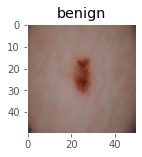

In [150]:
## Showing a randomly selected resized image
import random

# resize the image to smaller to not take up too much space
IMG_SIZE = 50
# randomly select 1 image from train set
img_path = random.choice(list(list_images(TRAIN_PATH)))
# take the class label from the folder name of the image
label = img_path.split(os.path.sep)[-2]

img = cv2.imread(img_path)
print(f"Original shape = {img.shape}")

# convert to RGB color because OpenCV still uses BGR color
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
print(f"Resized shape = {resized_img.shape}")

plt.figure(figsize=(2, 2))
plt.title(label)
plt.grid(False)
plt.imshow(resized_img)
plt.show()

# Loading data using the Second Method from Training Notebook

Because there is no third split provided in the original dataset, we will split 20% of the given train data into validation set.

In [151]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    shuffle=True,
    # 20% is used for validation set, defined in val_ds later
    validation_split=0.2,
    subset="training",
    seed=42, # a random seed, same seed is used to replicate same results
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    # DEFAULT MODE IS "int", which is integer label encoder
    # whiel 'categorical' is one-hot encoder
    label_mode='categorical'
)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.


In [152]:
CLASS_NAMES = train_ds.class_names
CLASS_NAMES

['benign', 'malignant']

In [153]:
total_train = len(train_ds.file_paths)
total_train

2110

This validation dataset `val_ds` will take the remaining data (not used for training) from `TRAIN_PATH` to use for validation, this is done by setting the same `validation_split` as we defined for `train_ds`, but a different `subset` as the parameters.

In [154]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    shuffle=False,
    seed=42,
    validation_split=0.2,
    subset="validation",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 2637 files belonging to 2 classes.
Using 527 files for validation.


In [155]:
total_val = len(val_ds.file_paths)
total_val

527

In [156]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    shuffle=False,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 660 files belonging to 2 classes.


In [157]:
total_test = len(test_ds.file_paths)
total_test

660

# Check loaded data of `image_dataset_from_directory()`

In [158]:
for batch_images, batch_labels in train_ds.take(1):
    print(batch_images[0].shape)
    print(batch_labels[0])

(224, 224, 3)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


# get_dataset() function

In [159]:
## Optimize for performance, just like the previous notebook
from functools import partial

def get_dataset(train_ds, val_ds, test_ds, preprocess_fn=None):
    def preprocess(image, label, preprocess_fn=preprocess_fn):
        image = preprocess_fn(image)
        return image, label

    # NOTE: TAKING ONLY a few batches for faster training
    # NOTE: MUST RUN THE image_dataset_from_directory() again if you want to
    #   change this sample_bs size AFTER TRAINING
    # sample_bs = 3
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = (train_ds
                # .take(sample_bs)
                .map(preprocess, num_parallel_calls=AUTOTUNE)
                .shuffle(BATCH_SIZE * 100)
                .cache()
                .prefetch(AUTOTUNE)
    )
    val_ds = (val_ds
            # .take(sample_bs)
            # no shuffle
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .cache()
            .prefetch(AUTOTUNE)
    )
    test_ds = (test_ds
            # .take(sample_bs)
            # no shuffle
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .cache()
            .prefetch(AUTOTUNE)
    )
    return train_ds, val_ds, test_ds

get_ds = partial(get_dataset, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds)
train, val, test = get_ds(preprocess_fn=preprocess_input)
len(train)

66

In [160]:
for x, y in train_ds.take(1):
    print(x.shape)
    print(y)

(32, 224, 224, 3)
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(32, 2), dtype=float32)


# get_model() function

We will use a ResNet50 (Residual Network with 50 layers) model as our pre-trained model, you may use any pre-trained models available in the Keras Applications module that can be referred [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

You can also read more about ResNet from a [blogpost here](https://www.mygreatlearning.com/blog/resnet/), or refer to the [official published paper](https://arxiv.org/abs/1512.03385).

For this model, we are using the Keras Functional API to build the model layers, where each layer is built in a way that's similar to calling a function, as opposed to the Sequential API that we have been using in the previous notebook.

In [161]:
def get_model(model_fn):
    tf.keras.backend.clear_session()
    # load the ResNet-50 network, ensuring the head fully connected (FC) layer sets are left
    # off so that we only take the important layers from the network
    print(f"[INFO] preparing model for {model_fn.__name__}...")

    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

    if 'nasnet' in model_fn.__name__.lower():
        # nasnet only supports a specific input_shape for "imagenet" weights,
        # check NASNetLarge and NASNetMobile docs for details
        # https://www.tensorflow.org/api_docs/python/tf/keras/applications/nasnet/NASNetLarge
        print("Not using imagenet weights")
        weights = None
    else:
        weights = "imagenet"

    baseModel = model_fn(
        weights=weights, include_top=False, input_shape=input_shape
    )

    # NOTE: CHECK THIS OUT for BATCHNORM FREEZING https://keras.io/guides/transfer_learning/#finetuning
    # OR THIS (same as above) https://www.tensorflow.org/guide/keras/transfer_learning

    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the training process. This is the common process
    # of transfer learning to make sure not to destroy the weights in the original
    # pre-trained model, you may choose to unfreeze all of them later to further fine-tune
    # to your custom dataset if you wish, but it is not certain whether there will be improvement
    # until you have tried it
    baseModel.trainable = False

    inputs = keras.Input(shape=input_shape)
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.
    headModel = baseModel(inputs, training=False)

    # construct the head of the model that will be placed on top of the
    # the base model
    # headModel = baseModel.output
    
    # then add extra layers to suit our choice
    error = True
    pool_sizes = (7, 5)
    for pool_size in pool_sizes:
        try:
            pooled = layers.AveragePooling2D(pool_size=pool_size)(headModel)
        except Exception as e:
            msg = e
            print(msg)
        else:
            error = False
            print(
                f"[INFO] Using AveragePooling2D with pool_size = {pool_size}")
            headModel = pooled

            headModel = layers.Flatten(name="flatten")(headModel)
            break
    if error:
        print(
            "Skipping AveragePooling2D layer due to small layer's input_size")
        print("Using GlobalAveragePooling2D layer")
        # GlobalAveragePooling2D does not need a Flatten layer
        headModel = layers.GlobalAveragePooling2D()(headModel)

    headModel = layers.Dense(256, activation="relu")(headModel)
    headModel = layers.Dropout(0.5)(headModel)

    # the last layer is the most important to ensure the model outputs
    #  the result that we want
    headModel = layers.Dense(len(CLASS_NAMES), activation="softmax")(headModel)

    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    # model = keras.Model(inputs=baseModel.input, outputs=headModel)
    model = keras.Model(inputs=inputs, outputs=headModel)

    # compile the model, setting a decay rate for our learning rate to 
    # slowly go down during the training to improve efficiency. This is
    # one way to control the updates of the model weights
    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
    # use sparse categorical crossentropy (CE) for integer label-encoded vector (`label_mode='int'`)
    # model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    # use normal categorical crossentropy (CE) for one-hot encoded vector (`label_mode='categorical'`)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [162]:
model_fn, preprocess_input = get_model_and_preprocess_func("ResNet50")
model = get_model(model_fn)
train_ds, val_ds, test_ds = get_ds(preprocess_fn=preprocess_input)
model_fn.__name__

[INFO] preparing model for ResNet50...
[INFO] Using AveragePooling2D with pool_size = 7


'ResNet50'

# Training

## ResNet50

In [163]:
# NOTE: ORIGINAL without preprocess_input! DO NOT TOUCH THIS! train the model
print("[INFO] Training model...")
start_time = time.perf_counter()
H = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS
)
end_time = time.perf_counter()
print(f"[INFO] Total time: {end_time - start_time:.2f} s")

[INFO] Training model...
Epoch 1/10
66/66 [==============================] - 13s 145ms/step - loss: 0.5983 - accuracy: 0.7246 - val_loss: 0.3473 - val_accuracy: 0.8463
Epoch 2/10
66/66 [==============================] - 9s 131ms/step - loss: 0.4096 - accuracy: 0.8308 - val_loss: 0.2799 - val_accuracy: 0.8880
Epoch 3/10
66/66 [==============================] - 9s 132ms/step - loss: 0.3593 - accuracy: 0.8474 - val_loss: 0.2311 - val_accuracy: 0.9089
Epoch 4/10
66/66 [==============================] - 9s 132ms/step - loss: 0.3277 - accuracy: 0.8573 - val_loss: 0.2083 - val_accuracy: 0.9203
Epoch 5/10
66/66 [==============================] - 8s 123ms/step - loss: 0.3020 - accuracy: 0.8739 - val_loss: 0.2249 - val_accuracy: 0.9089
Epoch 6/10
66/66 [==============================] - 8s 119ms/step - loss: 0.2822 - accuracy: 0.8801 - val_loss: 0.1715 - val_accuracy: 0.9317s: 0.2749 - accu - ETA: 3s - loss: 0.2809 -  - ETA: 3s - loss: 0.2944 - accuracy - ETA: 2s - loss: 0.2891 - accuracy - ETA:

## Visualize train results

Total epochs: 15
Min val_loss: 0.12903 at epoch 14



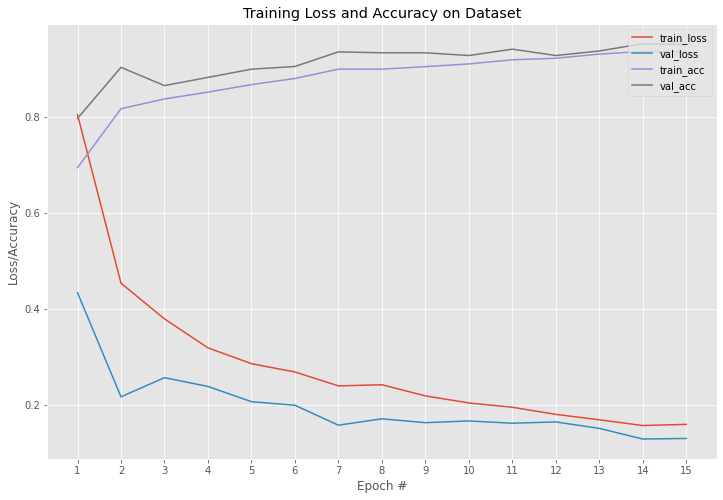

In [109]:
plot_train_res(H)

In [34]:
# NOTE: NEW WITH PREPROCESS_INPUT
print("[INFO] Training model...")
start_time = time.perf_counter()
H = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS
)
end_time = time.perf_counter()
print(f"[INFO] Total time: {end_time - start_time:.2f} s")

[INFO] Training model...
Epoch 1/10
66/66 [==============================] - 18s 155ms/step - loss: 0.6412 - accuracy: 0.7265 - val_loss: 0.2512 - val_accuracy: 0.8880
Epoch 2/10
66/66 [==============================] - 8s 127ms/step - loss: 0.4017 - accuracy: 0.8313 - val_loss: 0.2956 - val_accuracy: 0.8596
Epoch 3/10
66/66 [==============================] - 8s 127ms/step - loss: 0.3293 - accuracy: 0.8540 - val_loss: 0.2162 - val_accuracy: 0.9070
Epoch 4/10
66/66 [==============================] - 8s 127ms/step - loss: 0.2954 - accuracy: 0.8768 - val_loss: 0.2674 - val_accuracy: 0.8767
Epoch 5/10
66/66 [==============================] - 7s 113ms/step - loss: 0.2812 - accuracy: 0.8749 - val_loss: 0.2340 - val_accuracy: 0.8918
Epoch 6/10
66/66 [==============================] - 8s 120ms/step - loss: 0.2530 - accuracy: 0.8915 - val_loss: 0.1878 - val_accuracy: 0.9165
Epoch 7/10
66/66 [==============================] - 8s 123ms/step - loss: 0.2380 - accuracy: 0.8953 - val_loss: 0.1941 - v

# TRAIN FOR ALL MODELS

Note that some of these are using image size of only `(100, 100, 3)` to speed up the training process.

In [57]:
from IPython.display import display

for arch_name in arch2module_name:
    model_fn, preprocess_input = get_model_and_preprocess_func(arch_name)
    model = get_model(model_fn)
    display(preprocess_input)
    train_ds, val_ds, test_ds = get_ds(preprocess_fn=preprocess_input)
    print(f"[INFO] Training model for '{arch_name}'...")
    start_time = time.perf_counter()
    H = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5
    )
    end_time = time.perf_counter()
    print(f"[INFO] Total time: {end_time - start_time:.2f} s\n")

[INFO] preparing model for DenseNet121...


<function keras.applications.densenet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'DenseNet121'...
Epoch 1/5
66/66 [==============================] - 14s 150ms/step - loss: 0.6642 - accuracy: 0.6550 - val_loss: 0.4744 - val_accuracy: 0.7571
Epoch 2/5
66/66 [==============================] - 8s 119ms/step - loss: 0.4688 - accuracy: 0.7900 - val_loss: 0.4274 - val_accuracy: 0.7799
Epoch 3/5
66/66 [==============================] - 8s 118ms/step - loss: 0.4074 - accuracy: 0.8270 - val_loss: 0.4058 - val_accuracy: 0.8065
Epoch 4/5
66/66 [==============================] - 8s 124ms/step - loss: 0.3791 - accuracy: 0.8280 - val_loss: 0.3633 - val_accuracy: 0.8387
Epoch 5/5
66/66 [==============================] - 8s 119ms/step - loss: 0.3550 - accuracy: 0.8479 - val_loss: 0.3388 - val_accuracy: 0.8577
[INFO] Total time: 46.05 s

[INFO] preparing model for DenseNet169...


<function keras.applications.densenet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'DenseNet169'...
Epoch 1/5
66/66 [==============================] - 19s 201ms/step - loss: 0.6559 - accuracy: 0.6796 - val_loss: 0.3336 - val_accuracy: 0.8710
Epoch 2/5
66/66 [==============================] - 10s 158ms/step - loss: 0.4835 - accuracy: 0.7739 - val_loss: 0.2901 - val_accuracy: 0.8899
Epoch 3/5
66/66 [==============================] - 10s 154ms/step - loss: 0.4040 - accuracy: 0.8223 - val_loss: 0.2846 - val_accuracy: 0.8975
Epoch 4/5
66/66 [==============================] - 10s 151ms/step - loss: 0.3679 - accuracy: 0.8346 - val_loss: 0.2645 - val_accuracy: 0.8956
Epoch 5/5
66/66 [==============================] - 10s 159ms/step - loss: 0.3446 - accuracy: 0.8389 - val_loss: 0.2427 - val_accuracy: 0.9013
[INFO] Total time: 60.43 s

[INFO] preparing model for DenseNet201...


<function keras.applications.densenet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'DenseNet201'...
Epoch 1/5
66/66 [==============================] - 22s 222ms/step - loss: 0.5694 - accuracy: 0.7100 - val_loss: 0.4308 - val_accuracy: 0.8065
Epoch 2/5
66/66 [==============================] - 13s 200ms/step - loss: 0.4199 - accuracy: 0.8194 - val_loss: 0.3308 - val_accuracy: 0.8861
Epoch 3/5
66/66 [==============================] - 14s 209ms/step - loss: 0.3748 - accuracy: 0.8299 - val_loss: 0.3379 - val_accuracy: 0.8767
Epoch 4/5
66/66 [==============================] - 14s 207ms/step - loss: 0.3404 - accuracy: 0.8564 - val_loss: 0.2836 - val_accuracy: 0.8956
Epoch 5/5
66/66 [==============================] - 13s 201ms/step - loss: 0.3289 - accuracy: 0.8668 - val_loss: 0.2923 - val_accuracy: 0.8767
[INFO] Total time: 75.84 s

[INFO] preparing model for EfficientNetB0...
16719872/16705208 [==============================] - 1s 0us/step


<function keras.applications.efficientnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'EfficientNetB0'...
Epoch 1/5
66/66 [==============================] - 13s 123ms/step - loss: 0.5498 - accuracy: 0.7081 - val_loss: 0.4388 - val_accuracy: 0.7837
Epoch 2/5
66/66 [==============================] - 6s 98ms/step - loss: 0.4194 - accuracy: 0.7962 - val_loss: 0.4098 - val_accuracy: 0.8027
Epoch 3/5
66/66 [==============================] - 6s 93ms/step - loss: 0.3954 - accuracy: 0.8118 - val_loss: 0.3717 - val_accuracy: 0.8349
Epoch 4/5
66/66 [==============================] - 6s 93ms/step - loss: 0.3652 - accuracy: 0.8336 - val_loss: 0.3480 - val_accuracy: 0.8368
Epoch 5/5
66/66 [==============================] - 6s 92ms/step - loss: 0.3461 - accuracy: 0.8384 - val_loss: 0.3200 - val_accuracy: 0.8482
[INFO] Total time: 37.75 s

[INFO] preparing model for EfficientNetB1...
27033600/27018416 [==============================] - 2s 0us/step


<function keras.applications.efficientnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'EfficientNetB1'...
Epoch 1/5
66/66 [==============================] - 15s 149ms/step - loss: 0.5415 - accuracy: 0.7161 - val_loss: 0.4246 - val_accuracy: 0.7989
Epoch 2/5
66/66 [==============================] - 8s 128ms/step - loss: 0.4198 - accuracy: 0.8005 - val_loss: 0.3588 - val_accuracy: 0.8311
Epoch 3/5
66/66 [==============================] - 9s 137ms/step - loss: 0.3919 - accuracy: 0.8190 - val_loss: 0.3444 - val_accuracy: 0.8368
Epoch 4/5
66/66 [==============================] - 9s 132ms/step - loss: 0.3686 - accuracy: 0.8332 - val_loss: 0.3081 - val_accuracy: 0.8558
Epoch 5/5
66/66 [==============================] - 9s 134ms/step - loss: 0.3507 - accuracy: 0.8365 - val_loss: 0.3112 - val_accuracy: 0.8520
[INFO] Total time: 50.12 s

[INFO] preparing model for EfficientNetB2...
31801344/31790344 [==============================] - 2s 0us/step


<function keras.applications.efficientnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'EfficientNetB2'...
Epoch 1/5
66/66 [==============================] - 16s 165ms/step - loss: 0.5679 - accuracy: 0.7009 - val_loss: 0.4913 - val_accuracy: 0.7495
Epoch 2/5
66/66 [==============================] - 9s 140ms/step - loss: 0.4369 - accuracy: 0.8005 - val_loss: 0.4034 - val_accuracy: 0.8102
Epoch 3/5
66/66 [==============================] - 9s 140ms/step - loss: 0.3802 - accuracy: 0.8365 - val_loss: 0.3743 - val_accuracy: 0.8273
Epoch 4/5
66/66 [==============================] - 9s 138ms/step - loss: 0.3775 - accuracy: 0.8227 - val_loss: 0.3584 - val_accuracy: 0.8349
Epoch 5/5
66/66 [==============================] - 9s 137ms/step - loss: 0.3493 - accuracy: 0.8436 - val_loss: 0.3233 - val_accuracy: 0.8558
[INFO] Total time: 53.02 s

[INFO] preparing model for EfficientNetB3...
43950080/43941136 [==============================] - 3s 0us/step


<function keras.applications.efficientnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'EfficientNetB3'...
Epoch 1/5
66/66 [==============================] - 20s 211ms/step - loss: 0.5921 - accuracy: 0.6768 - val_loss: 0.5249 - val_accuracy: 0.7514
Epoch 2/5
66/66 [==============================] - 12s 181ms/step - loss: 0.4314 - accuracy: 0.8076 - val_loss: 0.4154 - val_accuracy: 0.8046
Epoch 3/5
66/66 [==============================] - 12s 176ms/step - loss: 0.3956 - accuracy: 0.8104 - val_loss: 0.3724 - val_accuracy: 0.8349
Epoch 4/5
66/66 [==============================] - 12s 178ms/step - loss: 0.3521 - accuracy: 0.8436 - val_loss: 0.3739 - val_accuracy: 0.8349
Epoch 5/5
66/66 [==============================] - 12s 179ms/step - loss: 0.3482 - accuracy: 0.8379 - val_loss: 0.3547 - val_accuracy: 0.8463
[INFO] Total time: 67.34 s

[INFO] preparing model for EfficientNetB4...
71696384/71686520 [==============================] - 5s 0us/step


<function keras.applications.efficientnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'EfficientNetB4'...
Epoch 1/5
66/66 [==============================] - 26s 275ms/step - loss: 0.5411 - accuracy: 0.7161 - val_loss: 0.4482 - val_accuracy: 0.7723
Epoch 2/5
66/66 [==============================] - 15s 235ms/step - loss: 0.4077 - accuracy: 0.8185 - val_loss: 0.3696 - val_accuracy: 0.8216
Epoch 3/5
66/66 [==============================] - 15s 232ms/step - loss: 0.3749 - accuracy: 0.8270 - val_loss: 0.3125 - val_accuracy: 0.8539
Epoch 4/5
66/66 [==============================] - 16s 236ms/step - loss: 0.3586 - accuracy: 0.8336 - val_loss: 0.2865 - val_accuracy: 0.8691
Epoch 5/5
66/66 [==============================] - 15s 231ms/step - loss: 0.3393 - accuracy: 0.8498 - val_loss: 0.3216 - val_accuracy: 0.8425
[INFO] Total time: 87.79 s

[INFO] preparing model for EfficientNetB5...
115277824/115263384 [==============================] - 9s 0us/step


<function keras.applications.efficientnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'EfficientNetB5'...
Epoch 1/5
66/66 [==============================] - 33s 360ms/step - loss: 0.5628 - accuracy: 0.6877 - val_loss: 0.4298 - val_accuracy: 0.7932
Epoch 2/5
66/66 [==============================] - 20s 308ms/step - loss: 0.4205 - accuracy: 0.7943 - val_loss: 0.3837 - val_accuracy: 0.8292
Epoch 3/5
66/66 [==============================] - 21s 313ms/step - loss: 0.3945 - accuracy: 0.8185 - val_loss: 0.3702 - val_accuracy: 0.8311
Epoch 4/5
66/66 [==============================] - 21s 314ms/step - loss: 0.3737 - accuracy: 0.8261 - val_loss: 0.3467 - val_accuracy: 0.8444
Epoch 5/5
66/66 [==============================] - 20s 308ms/step - loss: 0.3444 - accuracy: 0.8507 - val_loss: 0.3113 - val_accuracy: 0.8672
[INFO] Total time: 115.02 s

[INFO] preparing model for EfficientNetB6...
165249024/165234480 [==============================] - 13s 0us/step


<function keras.applications.efficientnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'EfficientNetB6'...
Epoch 1/5
66/66 [==============================] - 42s 462ms/step - loss: 0.5491 - accuracy: 0.7152 - val_loss: 0.4296 - val_accuracy: 0.7875
Epoch 2/5
66/66 [==============================] - 27s 407ms/step - loss: 0.4324 - accuracy: 0.8000 - val_loss: 0.4184 - val_accuracy: 0.7856
Epoch 3/5
66/66 [==============================] - 27s 406ms/step - loss: 0.3974 - accuracy: 0.8246 - val_loss: 0.3830 - val_accuracy: 0.8008
Epoch 4/5
66/66 [==============================] - 27s 407ms/step - loss: 0.3707 - accuracy: 0.8322 - val_loss: 0.3464 - val_accuracy: 0.8311
Epoch 5/5
66/66 [==============================] - 27s 407ms/step - loss: 0.3629 - accuracy: 0.8398 - val_loss: 0.3464 - val_accuracy: 0.8330
[INFO] Total time: 148.63 s

[INFO] preparing model for EfficientNetB7...
258088960/258076736 [==============================] - 20s 0us/step


<function keras.applications.efficientnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'EfficientNetB7'...
Epoch 1/5
66/66 [==============================] - 55s 625ms/step - loss: 0.5515 - accuracy: 0.7109 - val_loss: 0.4369 - val_accuracy: 0.7970
Epoch 2/5
66/66 [==============================] - 36s 552ms/step - loss: 0.4318 - accuracy: 0.8052 - val_loss: 0.3800 - val_accuracy: 0.8349
Epoch 3/5
66/66 [==============================] - 36s 552ms/step - loss: 0.3867 - accuracy: 0.8275 - val_loss: 0.3324 - val_accuracy: 0.8501
Epoch 4/5
66/66 [==============================] - 36s 553ms/step - loss: 0.3737 - accuracy: 0.8289 - val_loss: 0.3304 - val_accuracy: 0.8501
Epoch 5/5
66/66 [==============================] - 36s 553ms/step - loss: 0.3565 - accuracy: 0.8464 - val_loss: 0.2980 - val_accuracy: 0.8805
[INFO] Total time: 200.14 s

[INFO] preparing model for InceptionResNetV2...
219070464/219055592 [==============================] - 18s 0us/step


ValueError: Exception encountered when calling layer "average_pooling2d_19" (type AveragePooling2D).

Negative dimension size caused by subtracting 7 from 5 for '{{node average_pooling2d_19/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 7, 7, 1]](Placeholder)' with input shapes: [?,5,5,1536].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 5, 5, 1536), dtype=float32)

## Debugging error models

### Inception error with AveragePooling2D

In [50]:
from IPython.display import display

model_path = 'temp_model.h5'
start = False
for arch_name in arch2module_name:
    if not start:
        # start at the model with error to debug
        if arch_name == 'InceptionResNetV2':
            start = True
        else:
            continue
    model_fn, preprocess_input = get_model_and_preprocess_func(arch_name)
    model = get_model(model_fn)
    display(preprocess_input)
    train_ds, val_ds, test_ds = get_ds(preprocess_fn=preprocess_input)
    print(f"[INFO] Training model for '{arch_name}'...")
    start_time = time.perf_counter()
    H = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10
    )
    end_time = time.perf_counter()
    print(f"[INFO] Total time: {end_time - start_time:.2f} s\n")

    # model.evaluate(test_ds)

    print('[INFO] Trying to save and load the model ...')
    model.save(model_path, save_traces=True)
    start_time = time.perf_counter()
    # model = get_model(model_fn)
    # model = model.load_weights(model_path)  # must save weights only can load
    model = tf.keras.models.load_model(model_path, custom_objects=None)
    end_time = time.perf_counter()
    print(f"[INFO] Total time save & load: {end_time - start_time:.2f} s\n")

    # model.evaluate(test_ds)

    break

[INFO] preparing model for InceptionResNetV2...
Exception encountered when calling layer "average_pooling2d_1" (type AveragePooling2D).

Negative dimension size caused by subtracting 7 from 1 for '{{node average_pooling2d_1/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 7, 7, 1]](Placeholder)' with input shapes: [?,1,1,1536].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 1, 1536), dtype=float32)
Exception encountered when calling layer "average_pooling2d_2" (type AveragePooling2D).

Negative dimension size caused by subtracting 5 from 1 for '{{node average_pooling2d_2/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 5, 5, 1], padding="VALID", strides=[1, 5, 5, 1]](Placeholder)' with input shapes: [?,1,1,1536].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 1, 1536), dtype=float32)
Skipping AveragePooling2D layer due to small layer's input_size
Using GlobalAveragePooling2D layer


<function keras.applications.inception_resnet_v2.preprocess_input(x, data_format=None)>

[INFO] Training model for 'InceptionResNetV2'...
Epoch 1/10
66/66 [==============================] - 28s 128ms/step - loss: 0.8908 - accuracy: 0.6005 - val_loss: 0.5555 - val_accuracy: 0.7135
Epoch 2/10
66/66 [==============================] - 5s 78ms/step - loss: 0.6068 - accuracy: 0.7185 - val_loss: 0.4790 - val_accuracy: 0.7685
Epoch 3/10
66/66 [==============================] - 5s 79ms/step - loss: 0.5165 - accuracy: 0.7502 - val_loss: 0.3927 - val_accuracy: 0.8501
Epoch 4/10
66/66 [==============================] - 5s 80ms/step - loss: 0.4980 - accuracy: 0.7668 - val_loss: 0.4147 - val_accuracy: 0.8197
Epoch 5/10
66/66 [==============================] - 5s 76ms/step - loss: 0.4407 - accuracy: 0.7848 - val_loss: 0.3516 - val_accuracy: 0.8729
Epoch 6/10
66/66 [==============================] - 5s 76ms/step - loss: 0.4290 - accuracy: 0.8005 - val_loss: 0.3284 - val_accuracy: 0.8880
Epoch 7/10
66/66 [==============================] - 5s 83ms/step - loss: 0.4078 - accuracy: 0.8251 - va

In [53]:
# NOTE: THIS IS WITHOUT USING THE EXTRA DENSE + DROPOUT TO COMPARE
# Adding Dense + Dropout seems like performance improved much faster

model_path = 'temp_model.h5'
start = False
for arch_name in arch2module_name:
    if not start:
        # start at the model with error to debug
        if arch_name == 'InceptionResNetV2':
            start = True
        else:
            continue
    model_fn, preprocess_input = get_model_and_preprocess_func(arch_name)
    model = get_model(model_fn)
    display(preprocess_input)
    train_ds, val_ds, test_ds = get_ds(preprocess_fn=preprocess_input)
    print(f"[INFO] Training model for '{arch_name}'...")
    start_time = time.perf_counter()
    H = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10
    )
    end_time = time.perf_counter()
    print(f"[INFO] Total time: {end_time - start_time:.2f} s\n")

    # model.evaluate(test_ds)

    print('[INFO] Trying to save and load the model ...')
    model.save(model_path, save_traces=True)
    start_time = time.perf_counter()
    # model = get_model(model_fn)
    # model = model.load_weights(model_path)  # must save weights only can load
    model = tf.keras.models.load_model(model_path, custom_objects=None)
    end_time = time.perf_counter()
    print(f"[INFO] Total time save & load: {end_time - start_time:.2f} s\n")

    # model.evaluate(test_ds)

    break

[INFO] preparing model for InceptionResNetV2...
Exception encountered when calling layer "average_pooling2d_1" (type AveragePooling2D).

Negative dimension size caused by subtracting 7 from 1 for '{{node average_pooling2d_1/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 7, 7, 1]](Placeholder)' with input shapes: [?,1,1,1536].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 1, 1536), dtype=float32)
Exception encountered when calling layer "average_pooling2d_2" (type AveragePooling2D).

Negative dimension size caused by subtracting 5 from 1 for '{{node average_pooling2d_2/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 5, 5, 1], padding="VALID", strides=[1, 5, 5, 1]](Placeholder)' with input shapes: [?,1,1,1536].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 1, 1536), dtype=float32)
Skipping AveragePooling2D layer due to small layer's input_size
Using GlobalAveragePooling2D layer


<function keras.applications.inception_resnet_v2.preprocess_input(x, data_format=None)>

[INFO] Training model for 'InceptionResNetV2'...
Epoch 1/10
66/66 [==============================] - 15s 116ms/step - loss: 0.8195 - accuracy: 0.5545 - val_loss: 0.8423 - val_accuracy: 0.4801
Epoch 2/10
66/66 [==============================] - 5s 79ms/step - loss: 0.7102 - accuracy: 0.6137 - val_loss: 0.7445 - val_accuracy: 0.5427
Epoch 3/10
66/66 [==============================] - 5s 81ms/step - loss: 0.6457 - accuracy: 0.6488 - val_loss: 0.6848 - val_accuracy: 0.5939
Epoch 4/10
66/66 [==============================] - 5s 77ms/step - loss: 0.6025 - accuracy: 0.6839 - val_loss: 0.6432 - val_accuracy: 0.6281
Epoch 5/10
66/66 [==============================] - 5s 82ms/step - loss: 0.5712 - accuracy: 0.7066 - val_loss: 0.6116 - val_accuracy: 0.6546
Epoch 6/10
66/66 [==============================] - 6s 90ms/step - loss: 0.5474 - accuracy: 0.7289 - val_loss: 0.5863 - val_accuracy: 0.6603
Epoch 7/10
66/66 [==============================] - 6s 86ms/step - loss: 0.5286 - accuracy: 0.7403 - va

In [58]:
import gc
tf.keras.backend.clear_session()
gc.collect()

8896

### MobileNet error with AveragePooling2D

MobileNet seems to only work with `pool_size` of 1

In [74]:
from IPython.display import display

start = False
for arch_name in arch2module_name:
    if not start:
        # start at the model with error to debug
        if arch_name == 'MobileNetV3Large':
            start = True
        else:
            continue
    model_fn, preprocess_input = get_model_and_preprocess_func(arch_name)
    model = get_model(model_fn)
    display(preprocess_input)
    train_ds, val_ds, test_ds = get_ds(preprocess_fn=preprocess_input)
    print(f"[INFO] Training model for '{arch_name}'...")
    start_time = time.perf_counter()
    H = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10
    )
    end_time = time.perf_counter()
    print(f"[INFO] Total time: {end_time - start_time:.2f} s\n")

[INFO] preparing model for MobileNetV3Large...
Exception encountered when calling layer "average_pooling2d" (type AveragePooling2D).

Negative dimension size caused by subtracting 7 from 1 for '{{node average_pooling2d/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 7, 7, 1]](Placeholder)' with input shapes: [?,1,1,1280].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 1, 1280), dtype=float32)
Exception encountered when calling layer "average_pooling2d_1" (type AveragePooling2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node average_pooling2d_1/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 3, 3, 1]](Placeholder)' with input shapes: [?,1,1,1280].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 1, 1280), dtype=float32)
Exception encountered when calling layer "average_pooling2d_2" (type AveragePooling2D).

Negative dimension size 

<function keras.applications.mobilenet_v3.preprocess_input(x, data_format=None)>

[INFO] Training model for 'MobileNetV3Large'...
Epoch 1/10
66/66 [==============================] - 7s 68ms/step - loss: 0.6538 - accuracy: 0.6640 - val_loss: 0.3905 - val_accuracy: 0.8254
Epoch 2/10
66/66 [==============================] - 4s 57ms/step - loss: 0.4846 - accuracy: 0.7597 - val_loss: 0.3330 - val_accuracy: 0.8653
Epoch 3/10
66/66 [==============================] - 4s 60ms/step - loss: 0.4258 - accuracy: 0.7991 - val_loss: 0.2922 - val_accuracy: 0.8767
Epoch 4/10
66/66 [==============================] - 4s 58ms/step - loss: 0.3911 - accuracy: 0.8251 - val_loss: 0.2626 - val_accuracy: 0.8880
Epoch 5/10
66/66 [==============================] - 4s 57ms/step - loss: 0.3550 - accuracy: 0.8327 - val_loss: 0.2227 - val_accuracy: 0.9222
Epoch 6/10
66/66 [==============================] - 4s 57ms/step - loss: 0.3287 - accuracy: 0.8545 - val_loss: 0.2288 - val_accuracy: 0.9146
Epoch 7/10
66/66 [==============================] - 4s 57ms/step - loss: 0.3182 - accuracy: 0.8640 - val_l

<function keras.applications.mobilenet_v3.preprocess_input(x, data_format=None)>

[INFO] Training model for 'MobileNetV3Small'...
Epoch 1/10
66/66 [==============================] - 5s 44ms/step - loss: 0.5593 - accuracy: 0.7123 - val_loss: 0.4368 - val_accuracy: 0.8121
Epoch 2/10
66/66 [==============================] - 2s 31ms/step - loss: 0.4169 - accuracy: 0.8166 - val_loss: 0.3340 - val_accuracy: 0.8615
Epoch 3/10
66/66 [==============================] - 2s 32ms/step - loss: 0.3790 - accuracy: 0.8251 - val_loss: 0.2997 - val_accuracy: 0.8805
Epoch 4/10
66/66 [==============================] - 2s 32ms/step - loss: 0.3341 - accuracy: 0.8521 - val_loss: 0.2982 - val_accuracy: 0.8710
Epoch 5/10
66/66 [==============================] - 2s 32ms/step - loss: 0.3192 - accuracy: 0.8621 - val_loss: 0.2782 - val_accuracy: 0.8786
Epoch 6/10
66/66 [==============================] - 2s 31ms/step - loss: 0.3074 - accuracy: 0.8664 - val_loss: 0.2560 - val_accuracy: 0.8861
Epoch 7/10
66/66 [==============================] - 2s 30ms/step - loss: 0.2955 - accuracy: 0.8768 - val_l

<function keras.applications.nasnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'NASNetLarge'...
Epoch 1/10
66/66 [==============================] - 52s 580ms/step - loss: 0.6311 - accuracy: 0.6488 - val_loss: 0.5546 - val_accuracy: 0.6262
Epoch 2/10
66/66 [==============================] - 34s 518ms/step - loss: 0.5331 - accuracy: 0.7455 - val_loss: 0.4772 - val_accuracy: 0.7419
Epoch 3/10
66/66 [==============================] - 34s 516ms/step - loss: 0.4810 - accuracy: 0.7934 - val_loss: 0.4598 - val_accuracy: 0.7609
Epoch 4/10
66/66 [==============================] - 34s 516ms/step - loss: 0.4412 - accuracy: 0.8137 - val_loss: 0.4238 - val_accuracy: 0.7951
Epoch 5/10
66/66 [==============================] - 33s 501ms/step - loss: 0.4152 - accuracy: 0.8275 - val_loss: 0.3875 - val_accuracy: 0.8159
Epoch 6/10
66/66 [==============================] - 33s 507ms/step - loss: 0.3988 - accuracy: 0.8289 - val_loss: 0.3746 - val_accuracy: 0.8197
Epoch 7/10
66/66 [==============================] - 34s 521ms/step - loss: 0.3712 - accuracy: 0.843

<function keras.applications.nasnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'NASNetMobile'...
Epoch 1/10
66/66 [==============================] - 21s 168ms/step - loss: 0.6184 - accuracy: 0.6649 - val_loss: 0.4528 - val_accuracy: 0.8178
Epoch 2/10
66/66 [==============================] - 8s 117ms/step - loss: 0.4936 - accuracy: 0.7592 - val_loss: 0.3675 - val_accuracy: 0.8672
Epoch 3/10
66/66 [==============================] - 8s 117ms/step - loss: 0.4528 - accuracy: 0.7839 - val_loss: 0.3814 - val_accuracy: 0.8444
Epoch 4/10
66/66 [==============================] - 8s 123ms/step - loss: 0.4252 - accuracy: 0.8047 - val_loss: 0.3268 - val_accuracy: 0.8861
Epoch 5/10
66/66 [==============================] - 8s 117ms/step - loss: 0.4082 - accuracy: 0.8095 - val_loss: 0.3266 - val_accuracy: 0.8824
Epoch 6/10
66/66 [==============================] - 8s 117ms/step - loss: 0.3757 - accuracy: 0.8232 - val_loss: 0.2945 - val_accuracy: 0.8899
Epoch 7/10
66/66 [==============================] - 8s 117ms/step - loss: 0.3525 - accuracy: 0.8512 - v

<function keras.applications.resnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'ResNet101'...
Epoch 1/10
66/66 [==============================] - 19s 216ms/step - loss: 0.7011 - accuracy: 0.6981 - val_loss: 0.2956 - val_accuracy: 0.8729
Epoch 2/10
66/66 [==============================] - 13s 201ms/step - loss: 0.4556 - accuracy: 0.8024 - val_loss: 0.2434 - val_accuracy: 0.8899
Epoch 3/10
66/66 [==============================] - 13s 193ms/step - loss: 0.3890 - accuracy: 0.8351 - val_loss: 0.2238 - val_accuracy: 0.9051
Epoch 4/10
66/66 [==============================] - 12s 186ms/step - loss: 0.3337 - accuracy: 0.8512 - val_loss: 0.2449 - val_accuracy: 0.8843
Epoch 5/10
66/66 [==============================] - 12s 182ms/step - loss: 0.3187 - accuracy: 0.8607 - val_loss: 0.2482 - val_accuracy: 0.8843
Epoch 6/10
66/66 [==============================] - 12s 182ms/step - loss: 0.2888 - accuracy: 0.8825 - val_loss: 0.2309 - val_accuracy: 0.8899
Epoch 7/10
66/66 [==============================] - 13s 199ms/step - loss: 0.2651 - accuracy: 0.8839 

<function keras.applications.resnet_v2.preprocess_input(x, data_format=None)>

[INFO] Training model for 'ResNet101V2'...
Epoch 1/10
66/66 [==============================] - 19s 228ms/step - loss: 0.9365 - accuracy: 0.6109 - val_loss: 0.7251 - val_accuracy: 0.6319
Epoch 2/10
66/66 [==============================] - 13s 192ms/step - loss: 0.6519 - accuracy: 0.7052 - val_loss: 0.5722 - val_accuracy: 0.7078
Epoch 3/10
66/66 [==============================] - 13s 197ms/step - loss: 0.5322 - accuracy: 0.7412 - val_loss: 0.4981 - val_accuracy: 0.7628
Epoch 4/10
66/66 [==============================] - 13s 199ms/step - loss: 0.4679 - accuracy: 0.7758 - val_loss: 0.4439 - val_accuracy: 0.7894
Epoch 5/10
66/66 [==============================] - 13s 191ms/step - loss: 0.4155 - accuracy: 0.8085 - val_loss: 0.4349 - val_accuracy: 0.7913
Epoch 6/10
66/66 [==============================] - 13s 198ms/step - loss: 0.4049 - accuracy: 0.7991 - val_loss: 0.4413 - val_accuracy: 0.7970
Epoch 7/10
66/66 [==============================] - 13s 191ms/step - loss: 0.3776 - accuracy: 0.815

<function keras.applications.resnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'ResNet152'...
Epoch 1/10
66/66 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.7109

KeyboardInterrupt: 

In [75]:
from IPython.display import display

start = False
for arch_name in arch2module_name:
    if not start:
        # start at the model with error to debug
        if arch_name == 'ResNet152':
            start = True
        else:
            continue
    model_fn, preprocess_input = get_model_and_preprocess_func(arch_name)
    model = get_model(model_fn)
    display(preprocess_input)
    train_ds, val_ds, test_ds = get_ds(preprocess_fn=preprocess_input)
    print(f"[INFO] Training model for '{arch_name}'...")
    start_time = time.perf_counter()
    H = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5
    )
    end_time = time.perf_counter()
    print(f"[INFO] Total time: {end_time - start_time:.2f} s\n")

[INFO] preparing model for ResNet152...


<function keras.applications.resnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'ResNet152'...
Epoch 1/5
66/66 [==============================] - 27s 307ms/step - loss: 0.6550 - accuracy: 0.7412 - val_loss: 0.2830 - val_accuracy: 0.8880
Epoch 2/5
66/66 [==============================] - 17s 254ms/step - loss: 0.4549 - accuracy: 0.7981 - val_loss: 0.2160 - val_accuracy: 0.9184
Epoch 3/5
66/66 [==============================] - 18s 271ms/step - loss: 0.3712 - accuracy: 0.8289 - val_loss: 0.1872 - val_accuracy: 0.9203
Epoch 4/5
66/66 [==============================] - 19s 281ms/step - loss: 0.3395 - accuracy: 0.8450 - val_loss: 0.1801 - val_accuracy: 0.9260
Epoch 5/5
66/66 [==============================] - 18s 278ms/step - loss: 0.3090 - accuracy: 0.8649 - val_loss: 0.1464 - val_accuracy: 0.9412
[INFO] Total time: 98.71 s

[INFO] preparing model for ResNet152V2...
234561536/234545216 [==============================] - 24s 0us/step


<function keras.applications.resnet_v2.preprocess_input(x, data_format=None)>

[INFO] Training model for 'ResNet152V2'...
Epoch 1/5
66/66 [==============================] - 26s 297ms/step - loss: 0.7515 - accuracy: 0.6398 - val_loss: 0.4097 - val_accuracy: 0.8159
Epoch 2/5
66/66 [==============================] - 19s 287ms/step - loss: 0.5008 - accuracy: 0.7654 - val_loss: 0.4138 - val_accuracy: 0.7989
Epoch 3/5
66/66 [==============================] - 19s 284ms/step - loss: 0.4363 - accuracy: 0.8118 - val_loss: 0.3448 - val_accuracy: 0.8501
Epoch 4/5
66/66 [==============================] - 18s 276ms/step - loss: 0.3942 - accuracy: 0.8237 - val_loss: 0.3484 - val_accuracy: 0.8387
Epoch 5/5
66/66 [==============================] - 19s 290ms/step - loss: 0.3726 - accuracy: 0.8213 - val_loss: 0.2825 - val_accuracy: 0.8880
[INFO] Total time: 100.85 s

[INFO] preparing model for ResNet50...


<function keras.applications.resnet.preprocess_input(x, data_format=None)>

[INFO] Training model for 'ResNet50'...
Epoch 1/5
66/66 [==============================] - 12s 142ms/step - loss: 0.6759 - accuracy: 0.7223 - val_loss: 0.3961 - val_accuracy: 0.8178
Epoch 2/5
66/66 [==============================] - 8s 122ms/step - loss: 0.4484 - accuracy: 0.8071 - val_loss: 0.2792 - val_accuracy: 0.8861
Epoch 3/5
66/66 [==============================] - 8s 122ms/step - loss: 0.3768 - accuracy: 0.8322 - val_loss: 0.3020 - val_accuracy: 0.8748
Epoch 4/5
66/66 [==============================] - 8s 122ms/step - loss: 0.3160 - accuracy: 0.8550 - val_loss: 0.2708 - val_accuracy: 0.8861
Epoch 5/5
66/66 [==============================] - 8s 128ms/step - loss: 0.3027 - accuracy: 0.8597 - val_loss: 0.2589 - val_accuracy: 0.8861
[INFO] Total time: 44.90 s

[INFO] preparing model for ResNet50V2...
94683136/94668760 [==============================] - 8s 0us/step


<function keras.applications.resnet_v2.preprocess_input(x, data_format=None)>

[INFO] Training model for 'ResNet50V2'...
Epoch 1/5
66/66 [==============================] - 11s 121ms/step - loss: 0.7652 - accuracy: 0.6583 - val_loss: 0.5467 - val_accuracy: 0.7495
Epoch 2/5
66/66 [==============================] - 8s 120ms/step - loss: 0.5268 - accuracy: 0.7616 - val_loss: 0.4413 - val_accuracy: 0.8027
Epoch 3/5
66/66 [==============================] - 7s 110ms/step - loss: 0.4659 - accuracy: 0.7905 - val_loss: 0.4008 - val_accuracy: 0.8254
Epoch 4/5
66/66 [==============================] - 7s 106ms/step - loss: 0.4300 - accuracy: 0.7934 - val_loss: 0.3823 - val_accuracy: 0.8292
Epoch 5/5
66/66 [==============================] - 7s 110ms/step - loss: 0.3772 - accuracy: 0.8232 - val_loss: 0.2951 - val_accuracy: 0.8767
[INFO] Total time: 40.40 s

[INFO] preparing model for VGG16...
58900480/58889256 [==============================] - 4s 0us/step


<function keras.applications.vgg16.preprocess_input(x, data_format=None)>

[INFO] Training model for 'VGG16'...
Epoch 1/5
66/66 [==============================] - 19s 208ms/step - loss: 1.9762 - accuracy: 0.5915 - val_loss: 0.6585 - val_accuracy: 0.7609
Epoch 2/5
66/66 [==============================] - 7s 114ms/step - loss: 1.2893 - accuracy: 0.7014 - val_loss: 0.5958 - val_accuracy: 0.7799
Epoch 3/5
66/66 [==============================] - 8s 126ms/step - loss: 1.0379 - accuracy: 0.7308 - val_loss: 0.5075 - val_accuracy: 0.7837
Epoch 4/5
66/66 [==============================] - 8s 119ms/step - loss: 0.8787 - accuracy: 0.7607 - val_loss: 0.4449 - val_accuracy: 0.8046
Epoch 5/5
66/66 [==============================] - 8s 119ms/step - loss: 0.7769 - accuracy: 0.7635 - val_loss: 0.3920 - val_accuracy: 0.8254
[INFO] Total time: 50.52 s

[INFO] preparing model for VGG19...
80150528/80134624 [==============================] - 8s 0us/step


<function keras.applications.vgg19.preprocess_input(x, data_format=None)>

[INFO] Training model for 'VGG19'...
Epoch 1/5
66/66 [==============================] - 11s 147ms/step - loss: 1.8355 - accuracy: 0.6284 - val_loss: 0.7694 - val_accuracy: 0.6869
Epoch 2/5
66/66 [==============================] - 9s 142ms/step - loss: 1.1399 - accuracy: 0.6995 - val_loss: 0.5100 - val_accuracy: 0.8065
Epoch 3/5
66/66 [==============================] - 10s 148ms/step - loss: 0.9153 - accuracy: 0.7502 - val_loss: 0.5896 - val_accuracy: 0.7723
Epoch 4/5
66/66 [==============================] - 10s 145ms/step - loss: 0.7927 - accuracy: 0.7725 - val_loss: 0.5210 - val_accuracy: 0.7761
Epoch 5/5
66/66 [==============================] - 9s 143ms/step - loss: 0.7025 - accuracy: 0.7791 - val_loss: 0.4179 - val_accuracy: 0.8178
[INFO] Total time: 49.49 s

[INFO] preparing model for Xception...
83697664/83683744 [==============================] - 7s 0us/step


<function keras.applications.xception.preprocess_input(x, data_format=None)>

[INFO] Training model for 'Xception'...
Epoch 1/5
66/66 [==============================] - 14s 164ms/step - loss: 0.5908 - accuracy: 0.6825 - val_loss: 0.4755 - val_accuracy: 0.7666
Epoch 2/5
66/66 [==============================] - 10s 146ms/step - loss: 0.4777 - accuracy: 0.7777 - val_loss: 0.3803 - val_accuracy: 0.8311
Epoch 3/5
66/66 [==============================] - 9s 140ms/step - loss: 0.4280 - accuracy: 0.7981 - val_loss: 0.3836 - val_accuracy: 0.8235
Epoch 4/5
66/66 [==============================] - 10s 146ms/step - loss: 0.3988 - accuracy: 0.8152 - val_loss: 0.3491 - val_accuracy: 0.8425
Epoch 5/5
66/66 [==============================] - 9s 138ms/step - loss: 0.3658 - accuracy: 0.8384 - val_loss: 0.3409 - val_accuracy: 0.8520
[INFO] Total time: 51.22 s



# Save and check training result

In [30]:
# serialize the model to disk
print("[INFO] saving model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] saving model...


C:\Users\user\anaconda3\envs\tfod\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Total epochs: 10
Min val_loss: 0.17224 at epoch 9



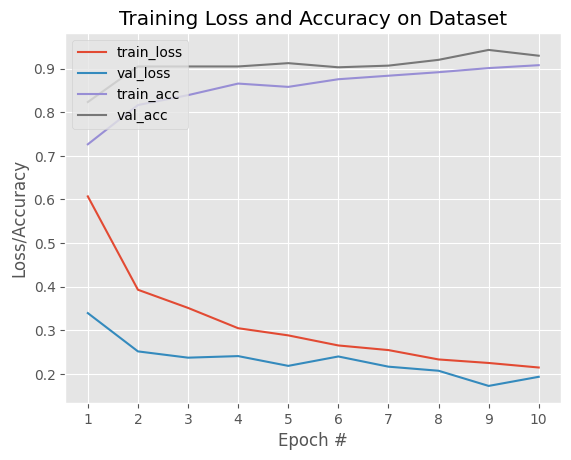

In [31]:
# plot the training and validation results
val_loss = H.history["val_loss"]
min_val_loss = np.min(val_loss)
epoch_min_val_loss = val_loss.index(min_val_loss) + 1
total_epochs = len(val_loss)
print(f"Total epochs: {total_epochs}")
print(f"Min val_loss: {min_val_loss:.5f} at epoch {epoch_min_val_loss}\n")

N = NUM_EPOCHS
plt.style.use("ggplot")
plt.xticks(np.arange(1, N + 1))
plt.plot(np.arange(1, N + 1), H.history["loss"], label="train_loss")
plt.plot(np.arange(1, N + 1), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(1, N + 1), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, N + 1), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# save the figure
plt.savefig(PLOT_PATH)
plt.show()

# Evaluation

Similar to our previous notebook.

In [32]:
# Load entire saved model directly
start_time = time.perf_counter()
print(f"[INFO] Loading model ...")
model = tf.keras.models.load_model(MODEL_PATH)
end_time = time.perf_counter()
print(f"[INFO] Done. [{end_time - start_time:.2f} s]")

[INFO] Loading model ...
[INFO] Done. [1.40 s]


In [33]:
# show the accuracy on the validation set
(loss, accuracy) = model.evaluate(val_ds)
print("[INFO] Validation Accuracy: {:.2f}%".format(accuracy * 100))
(loss, accuracy) = model.evaluate(test_ds)
print("[INFO] Testing Accuracy: {:.2f}%".format(accuracy * 100))

17/17 [==============================] - 4s 159ms/step - loss: 0.1932 - accuracy: 0.9298
[INFO] Validation Accuracy: 92.98%
21/21 [==============================] - 4s 192ms/step - loss: 0.2910 - accuracy: 0.8682
[INFO] Testing Accuracy: 86.82%


In [34]:
%%time
preds = model.predict(test_ds)
preds.shape

Wall time: 3.95 s


(660, 2)

In [35]:
preds = np.argmax(preds, axis=-1)
preds.shape

(660,)

In [36]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true.shape

(660,)

In [37]:
from sklearn.metrics import classification_report

# show a nicely formatted classification report
classif_report = classification_report(
    y_true, preds, target_names=CLASS_NAMES
)
print(classif_report)
with open(CLASSIF_REPORT_PATH, "w") as f:
    f.write(classif_report)

              precision    recall  f1-score   support

      benign       0.89      0.86      0.88       360
   malignant       0.84      0.87      0.86       300

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660



In [44]:
np.sum(cm)

660

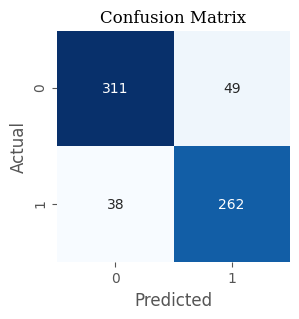

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, preds)

fig = plt.figure(figsize=(3, 3))
ax = sns.heatmap(
    cm,
    cmap="Blues",
    annot=True,
    fmt="d",
    cbar=False,
)

plt.title("Confusion Matrix", size=12, fontfamily="serif")
plt.savefig(os.path.join(OUTPUTS_PATH, "cm_skin_cancer.png"))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()